In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, cohen_kappa_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier

In [50]:
df = pd.read_csv("df_norm.csv", 
                 index_col = 0)

In [54]:
class_names = df['CLASS']
class_names = class_names.tolist()
col_names = df.columns
class_label = np.unique(class_names)

In [58]:
df.shape

(200, 35)

In [62]:
X = df.drop('CLASS',axis=1)
Y = df['CLASS']

In [66]:
Y_bin = label_binarize(df['CLASS'], 
                       classes=class_label)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    Y_bin, 
                                                    test_size=0.2,
                                                    stratify=class_names)
y_true = np.argmax(y_test, axis = 1) ## VETORIZANDO PARA AS FUNCOES ABAIXO

# XGBoost

In [74]:
from xgboost import XGBClassifier

In [77]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in lr_list:
    xgb_clf = OneVsRestClassifier(XGBClassifier(eval_metric='mlogloss',
                                                use_label_encoder=False,
                                                learning_rate=learning_rate))

    xgb_fit = xgb_clf.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(xgb_fit.score(X_train, y_train)))
    print("Accuracy score (teste): {0:.3f}".format(xgb_fit.score(X_test, y_test)))

Learning rate:  0.05
Accuracy score (training): 1.000
Accuracy score (teste): 0.900
Learning rate:  0.075
Accuracy score (training): 1.000
Accuracy score (teste): 0.900
Learning rate:  0.1
Accuracy score (training): 1.000
Accuracy score (teste): 0.925
Learning rate:  0.25
Accuracy score (training): 1.000
Accuracy score (teste): 0.900
Learning rate:  0.5
Accuracy score (training): 1.000
Accuracy score (teste): 0.875
Learning rate:  0.75
Accuracy score (training): 1.000
Accuracy score (teste): 0.900
Learning rate:  1
Accuracy score (training): 1.000
Accuracy score (teste): 0.900


Best lr

In [79]:
xgb_clf = OneVsRestClassifier(XGBClassifier(eval_metric='mlogloss',
                                                use_label_encoder=False,
                                                learning_rate=0.075))

y_predp_ovr_xgb = xgb_clf.fit(X_train, y_train).predict_proba(X_test)
y_pred_ovr_xgb = xgb_clf.fit(X_train, y_train).predict(X_test)
y_pred_xgb = np.argmax(y_pred_ovr_xgb, axis=1)

In [81]:
xgb_cm = confusion_matrix(y_true=y_true, 
                          y_pred=y_pred_xgb)

Text(0.5, 1.0, 'Heatmap for X Gradient Boosting Classification Model')

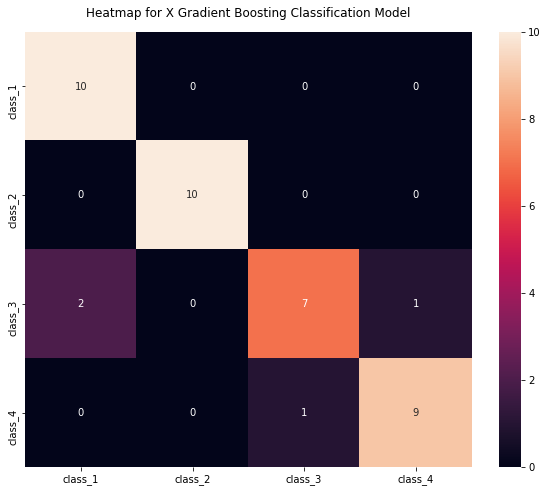

In [83]:
plt.figure(figsize = (10,8))
ax = plt.axes()
x_axis_labels = ['class_1', 'class_2', 'class_3', 'class_4'] # labels for x-axis
y_axis_labels = ['class_1', 'class_2', 'class_3', 'class_4'] # labels for y-axis
sns.heatmap(xgb_cm,
            vmin=0,
            vmax=10,
            annot=True,
            fmt="d",
            ax = ax,
            xticklabels=x_axis_labels, 
            yticklabels=y_axis_labels)
ax.set_title('Heatmap for X Gradient Boosting Classification Model',pad=15)

In [85]:
print(classification_report(y_true, y_pred_xgb, target_names=class_label))
print("Accuracy:",metrics.accuracy_score(y_true, y_pred_xgb))

              precision    recall  f1-score   support

     class_1       0.83      1.00      0.91        10
     class_2       1.00      1.00      1.00        10
     class_3       0.88      0.70      0.78        10
     class_4       0.90      0.90      0.90        10

    accuracy                           0.90        40
   macro avg       0.90      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40

Accuracy: 0.9


In [87]:
# Compute ROC curve and ROC area for each class
fpr_xgb = dict()
tpr_xgb = dict()
roc_auc_xgb = dict()
for i in range(class_label.shape[0]):
    fpr_xgb[i], tpr_xgb[i], _ = roc_curve(y_test[:, i], y_pred_ovr_xgb[:, i])
    roc_auc_xgb[i] = auc(fpr_xgb[i], tpr_xgb[i])

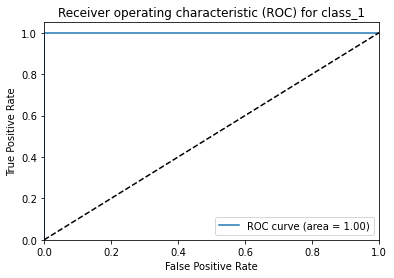

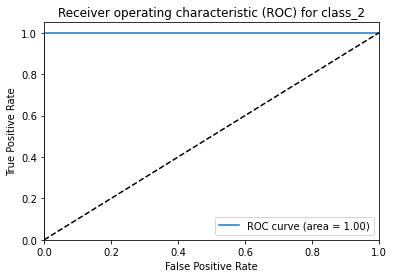

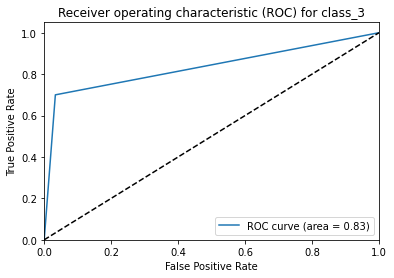

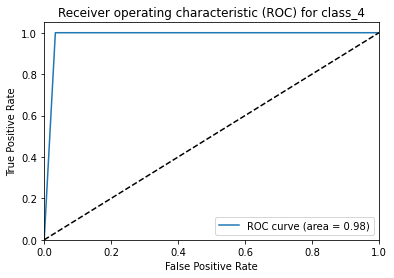

In [89]:
for i in range(class_label.shape[0]):
    plt.figure()
    plt.plot(fpr_xgb[i], tpr_xgb[i], label='ROC curve (area = %0.2f)' % roc_auc_xgb[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) for %s' % class_label[i])
    plt.legend(loc="lower right")
    plt.show()

In [90]:
DT_kappa = cohen_kappa_score(y_true, y_pred_xgb)
DT_kappa

0.8666666666666667

In [91]:
FP = xgb_cm.sum(axis=0) - np.diag(xgb_cm) 
FN = xgb_cm.sum(axis=1) - np.diag(xgb_cm)
TP = np.diag(xgb_cm)
TN = xgb_cm.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensibilidade, taxa de acerto, recall ou taxa de true positive 
TPR = TP/(TP+FN)
print("Sensibilidade:\t", TPR)
# Especificidade ou taxa de true negative
TNR = TN/(TN+FP) 
print("True Negative:\t", TNR)
# Precisao
PPV = TP/(TP+FP)
print("Precisão:\t", PPV)
# Predicao negativa
NPV = TN/(TN+FN)
print("Pred. Negativa:\t", NPV)
# False positive
FPR = FP/(FP+TN)
print("False Positive: ", FPR)
# False negative
FNR = FN/(TP+FN)
print("False Negative:\t", FNR)
# False discovery
FDR = FP/(TP+FP)
print("F Discovery:\t", FDR)
# Accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Acurácia:\t", ACC)    

Sensibilidade:	 [1.  1.  0.7 0.9]
True Negative:	 [0.93333333 1.         0.96666667 0.96666667]
Precisão:	 [0.83333333 1.         0.875      0.9       ]
Pred. Negativa:	 [1.         1.         0.90625    0.96666667]
False Positive:  [0.06666667 0.         0.03333333 0.03333333]
False Negative:	 [0.  0.  0.3 0.1]
F Discovery:	 [0.16666667 0.         0.125      0.1       ]
Acurácia:	 [0.95 1.   0.9  0.95]
